# Dynamic optimization of walking on uneven terrain

A simple walking model is optimized to walk over uneven terrain. The
objective is to minimize energy expenditure, quantified by the push-off
work performed with each step. The optimization here seeks to traverse a
stretch of terrain, starting and ending at level walking, and taking the
same amount of time as level walking.

## Walk over a single upward step

The optimal compensation for a single upward step is to speed up
beforehand, lose speed stepping upward, and then speed up again
afterward. The optimal speed-ups both occur over several steps but have
different shapes: the first one increases nearly exponentially with
time, and the second one resembles a saturating exponential. The
optimization is described by Darici et al. (2020), and tested with human
subjects experiment (Darici and Kuo 2022).

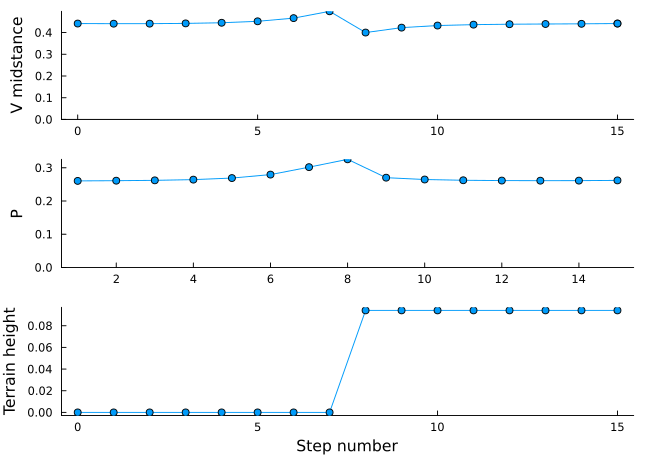

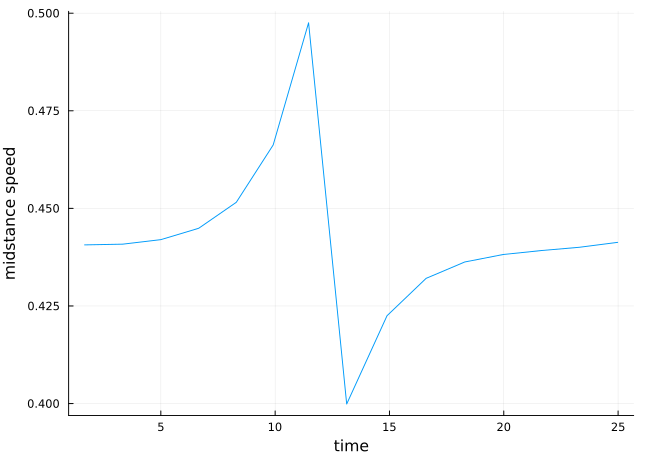

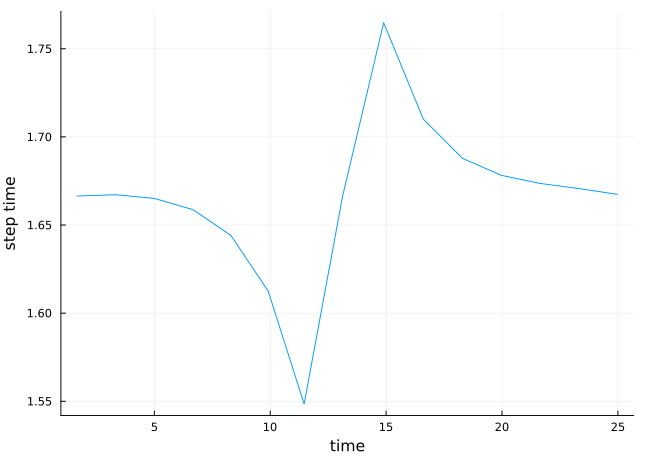

In [1]:
using DynLoco, Plots; 

wstar4s = findgait(WalkRW2l(α=0.4102,safety=true), target=:speed=>0.4789, varying=:P)
nsteps = 15
bumpHeightDimless = 0.075
B  = asin(bumpHeightDimless / (2*sin(wstar4s.α)))
δs = zeros(nsteps); δs[Int((nsteps+1)/2)] = B # one bump
upstepresult = optwalk(wstar4s, nsteps, boundarywork=false, δs=δs)

p = multistepplot(upstepresult, boundarywork=false, legend=false) # plot speed, push-off, terrain heights
display(p)

p = plot(cumsum(upstepresult.steps.tf), upstepresult.steps.vm,xlabel="time",ylabel="midstance speed",legend=false)
display(p)

# step timings, per step
plot(cumsum(upstepresult.steps.tf),upstepresult.steps.tf, xlabel="time",ylabel="step time", legend=false)

The optimization is performed with `optwalk`, which computes the
minimum-work trajectory for `nsteps` of walking. A terrain may be
provided by an array of height/angle changes `δs`.

All quantities are plotted in dimensionless form, with base units of
body mass $M$, leg length $L$, and gravitational acceleration $g$. Thus
speed is normalized by $\sqrt(gL)$ and time by $\sqrt(L/g)$. For a
typical leg length of $L = 1\,\mathrm{m}$, the equivalent dimensional
speed is about 1.25 m/s, and step time about 0.55 s.

## Use varying step lengths to walk over a single upward step

The model above uses fixed step lengths, whereas humans adjust step
length with speed. The model can also be constrained to step at the
preferred step length vs speed relationship of human, resulting in a
different amplitude of speed fluctuations, but a similarly-shaped speed
profile.

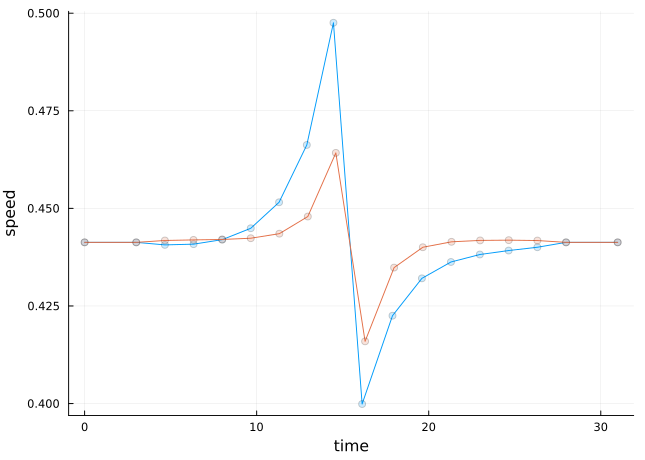

In [2]:
# WalkRW2ls has varying step lengths according to preferred human
wstar4ls = findgait(WalkRW2ls(α=0.4102,safety=true), target=:speed=>0.4789, varying=:P, cstep=0.35, vmstar=wstar4s.vm)
varyingresult = optwalk(wstar4ls, nsteps, boundarywork=false,δs=δs)
plotvees(upstepresult,boundaryvels=upstepresult.boundaryvels, speedtype=:midstance)
plotvees!(varyingresult,boundaryvels=upstepresult.boundaryvels, speedtype=:midstance)

## Walk over a bunch of terrains

The terrain is specified as a series of angle/height changes each step.
The task is to start and end with nominal level walking, and to traverse
the terrain in minimum energy, in the same amount of time as for level
walking.

Note that terrain profile is not plotted to scale.

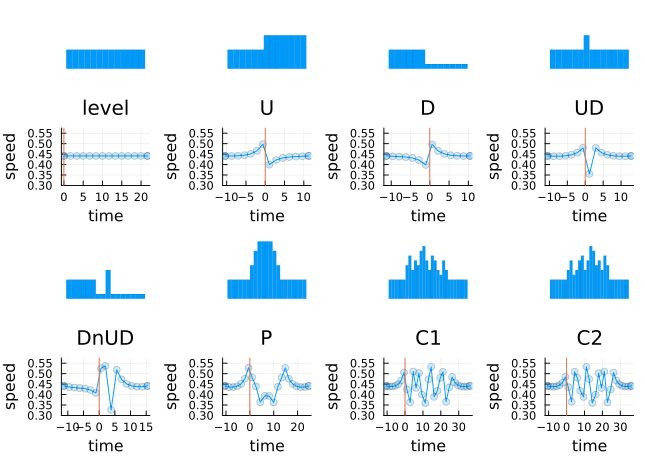

In [3]:
## plot bumps and speed trajectories of all 8 terrains
numStepsBefore = 6; numStepsAfter = 6
# all terrain trajectories
wstar4s = findgait(WalkRW2l(α=0.4102,safety=true), target=:speed=>0.4789, varying=:P)

δs = ( # terrain defined a sequence of height or angle changes from previous step
    "level" =>[zeros(numStepsBefore); [0] .* B; zeros(numStepsAfter)], # level   
    "U" =>    [zeros(numStepsBefore); [1] .* B; zeros(numStepsAfter)], # Up
    "D" =>    [zeros(numStepsBefore); [-1] .* B; zeros(numStepsAfter)], # Down
    "UD" =>   [zeros(numStepsBefore); [1, -1] .* B; zeros(numStepsAfter)], # Up-Down
    "DnUD" => [zeros(numStepsBefore); [-1, 0, 5/3, -5/3] .* B; zeros(numStepsAfter)] , # Down & Up-Down
    "P" =>    [zeros(numStepsBefore); [ 1, 1, 1, 0, 0, 0, -1, -1, -1] .* B; zeros(numStepsAfter)], # Pyramid
    "C1" =>   [zeros(numStepsBefore); [ 3, 2, -3, 2, -1, 3, 1, -3, -2, 3, -1, -2, -1, 3, -2, -2] .* B/3; zeros(numStepsAfter)], # Complex 1
    "C2" =>   [zeros(numStepsBefore); [ 2, 2, -3, 1, 2, 1, -3, 2, 3, -1,  -3,  1, -2, 3, -2, -3] .* B/3; zeros(numStepsAfter)], # Complex 2
)

p = plot(layout=(4,4), legend=false); 
pslotnum(n) = n + (n>4 ? 4 : 0) # plot in slots 1 - 4, 9 - 12
for (i,(terrainname, terrainbumps)) in enumerate(δs)
    # plot the terrain profile in space (not to scale)
    plotterrain!(p[pslotnum(i)], cumsum(terrainbumps)./B .* bumpHeightDimless, setfirstbumpstep=true,ylims=(-0.1,0.2),showaxis=false,grid=false)
    # minimum-work strategy for terrain
    results = optwalk(wstar4s, length(terrainbumps), δs=terrainbumps, boundarywork = false) # optimizing push-offs (boundarywork=false means start from nominal walking)
    plotvees!(p[pslotnum(i)+4], results, boundaryvels=results.boundaryvels, speedtype=:midstance, setfirstbumpstep=true,title=terrainname, tchange = 0, ylims=(0.3,0.575))
    vline!(p[pslotnum(i)+4], [0]) # mark where the first uneven step is
end
display(p)

## Walk over a simple bump with no compensation

Model walks with constant push-offs for steady walking, and encounters
the up-step without any compensation. As a result of the unexpected
upward step, the model loses speed, and with repeated constant
push-offs, will eventually regain nominal speed. The number of regaining
steps is described by the persistence distance. This model expends the
same energy as level walking, but accumulates a time deficit compared to
minimum-work compensation. Walking over a bump generally requires more
time or more work. More detail is available from Darici, Temeltas, and
Kuo (2020).

No compensation total work cost = 0.4433306466750797
Min-work compensation total work cost = 0.5538343313152624

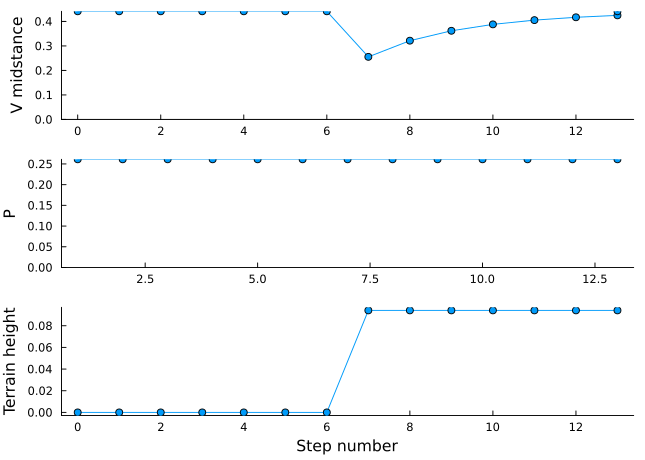

Final time deficit = -1.2734506601085016

In [4]:
upstep = δs[2][2] # up-step terrain, get the terrain array
nsteps = length(upstep)
nocompresult = multistep(wstar4s, Ps=fill(wstar4s.P,nsteps),δangles=upstep,boundaryvels=(wstar4s.vm,wstar4s.vm))
println("No compensation total work cost = ", nocompresult.totalcost)
println("Min-work compensation total work cost = ", upstepresult.totalcost)
p = multistepplot(nocompresult, legend=false, boundarywork=false)
display(p)
plot(cumsum(upstepresult.steps.tf),label="min work")
plot!(cumsum(nocompresult.steps.tf), xlabel="step",ylabel="accumulated time", label="no compensation")
println("Final time deficit = ", -sum(upstepresult.steps.tf)+sum(nocompresult.steps.tf))

## Walk over a single bump with a reactive compensation

Here the model does not anticipate the up-step and loses speed and time
upon first contact with it. Thereafter, the model compensates and
catches up to the level ground model by looking ahead and adjusting the
trajectory of push-offs. This strategy therefore actually anticipates
and optimally compensates for all steps other the first uneven one. It
is almost impossible to regain time without some knowledge and goal for
the terrain ahead. More detail is available from Darici, Temeltas, and
Kuo (2020).

Reactive contrl total work cost = 0.5756333115295249
Up-step min-work control total work cost = 0.5538343313152624

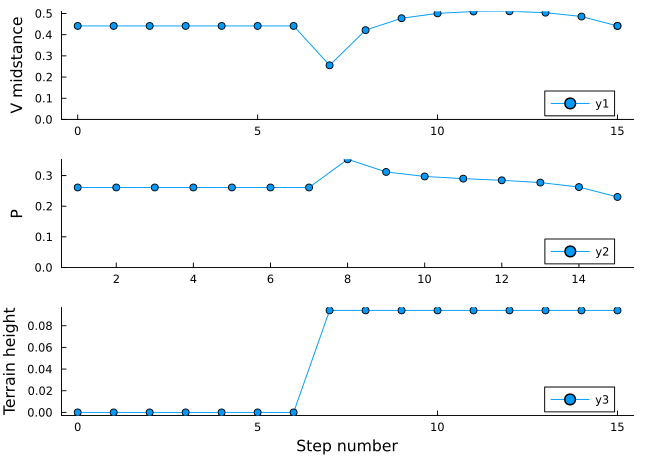

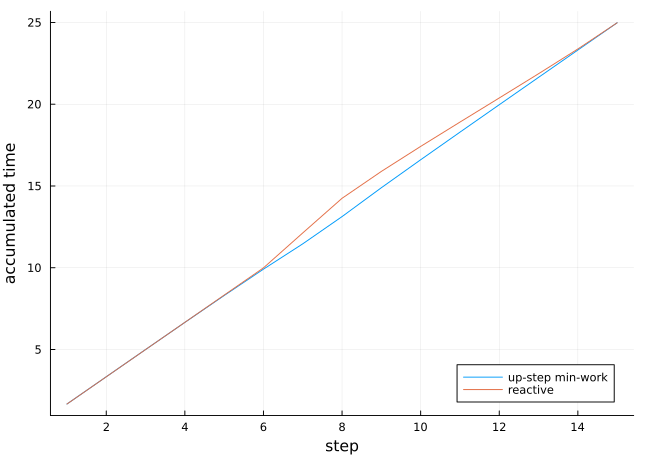

Final time deficit = 2.1316282072803006e-14

In [5]:
nbump = Int(floor((nsteps+1)/2))
reactresults1 = multistep(wstar4s, Ps=fill(wstar4s.P,nbump),δangles=upstep[1:nbump],boundaryvels=(wstar4s.vm,wstar4s.vm))
reactresults2 = optwalk(wstar4s, length(upstepresult.steps)-nbump, totaltime = upstepresult.totaltime - reactresults1.totaltime,boundaryvels=(reactresults1.steps[end].vm,wstar4s.vm), boundarywork=(false,false))
reactresult = cat(reactresults1, reactresults2)
println("Reactive contrl total work cost = ", reactresult.totalcost)
println("Up-step min-work control total work cost = ", upstepresult.totalcost)
p = multistepplot(reactresult,boundarywork=false) # plot concatenation of two simulations
display(p)
p = plot(cumsum(upstepresult.steps.tf),label="up-step min-work")
plot!(p, cumsum(reactresult.steps.tf), xlabel="step",ylabel="accumulated time", label="reactive")
display(p)
println("Final time deficit = ", -sum(upstepresult.steps.tf)+sum(reactresult.steps.tf))

# Julia code

This page is viewable as [Jupyter notebook](uneventerrain.ipynb), [plain
Julia](uneventerrain.jl) text, or [HTML](uneventerrain.html).

# Matlab code

There is also extensive Matlab code for an earlier implementation of the
same model. See [Matlab directory](../matlab). There is very limited
documentation of this code.

## Experimental data

The data from accompanying human subjects experiment are available in a
[separate data and code
repository](https://github.com/kuo-lab/uneventerrainexperiment/). The
code is in Matlab, and the data files are in .mat format, which is
compatible with HDF5.

## References

Darici, Osman, and Arthur D. Kuo. 2022. “Humans Optimally Anticipate and
Compensate for an Uneven Step During Walking.” Edited by Lena H Ting.
*eLife* 11 (January): e65402. <https://doi.org/10.7554/eLife.65402>.

Darici, Osman, Hakan Temeltas, and Arthur D. Kuo. 2020. “Anticipatory
Control of Momentum for Bipedal Walking on Uneven Terrain.” *Scientific
Reports* 10 (1): 540. <https://doi.org/10.1038/s41598-019-57156-6>.